In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set()

import os
import zipfile
import cv2
import random

import torch
from torch import nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import torch.optim as optim

import warnings
warnings.filterwarnings('ignore')

In [59]:
Healthy_plants_dir = "Plants Images/Early_Blight"
Diseased_plants_dir = "Plants Images/Healthy"

healthy_images = os.listdir(Healthy_plants_dir)
diseased_images = os.listdir(Diseased_plants_dir)

num_healthy_images = len(os.listdir(Healthy_plants_dir))
num_diseased_images = len(os.listdir(Diseased_plants_dir))


In [60]:
print(f'Number of Healthy Plant images: {num_healthy_images}')
print(f'Number of Diseased Plant images: {num_diseased_images}')

Number of Healthy Plant images: 1542
Number of Diseased Plant images: 1521


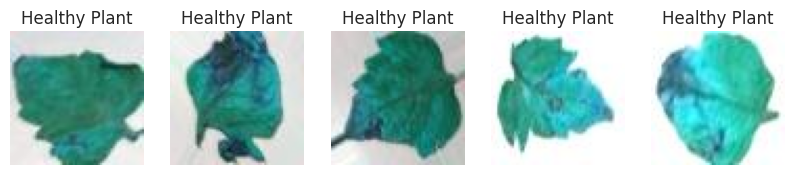

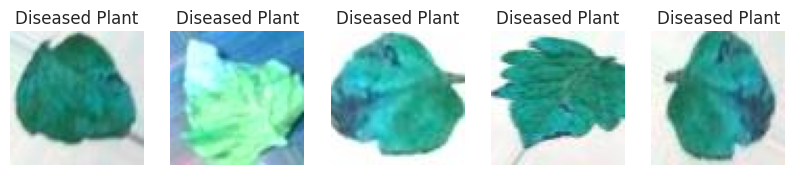

In [61]:
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    img = mpimg.imread(os.path.join(Healthy_plants_dir, healthy_images[i]))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Healthy Plant')
plt.show()

plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    img = mpimg.imread(os.path.join(Diseased_plants_dir, diseased_images[i]))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Diseased Plant')
plt.show()

In [72]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

data_dir = "Plants Images"
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Split the dataset
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [81]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(weights="IMAGENET1K_V1")

for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [82]:
for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss = running_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")



Epoch 1/50, Train Loss: 0.7541, Train Acc: 0.4874, Val Loss: 0.7089, Val Acc: 0.5049
Epoch 2/50, Train Loss: 0.7141, Train Acc: 0.5252, Val Loss: 0.7914, Val Acc: 0.5163
Epoch 3/50, Train Loss: 0.7061, Train Acc: 0.5215, Val Loss: 0.7364, Val Acc: 0.4788
Epoch 4/50, Train Loss: 0.7105, Train Acc: 0.5480, Val Loss: 0.7966, Val Acc: 0.5065
Epoch 5/50, Train Loss: 0.7100, Train Acc: 0.5271, Val Loss: 0.7491, Val Acc: 0.4673
Epoch 6/50, Train Loss: 0.7023, Train Acc: 0.5336, Val Loss: 0.7426, Val Acc: 0.4739
Epoch 7/50, Train Loss: 0.6846, Train Acc: 0.5620, Val Loss: 0.8058, Val Acc: 0.4722
Epoch 8/50, Train Loss: 0.6919, Train Acc: 0.5648, Val Loss: 0.8533, Val Acc: 0.5147
Epoch 9/50, Train Loss: 0.7191, Train Acc: 0.5215, Val Loss: 0.7833, Val Acc: 0.4739
Epoch 10/50, Train Loss: 0.7043, Train Acc: 0.5466, Val Loss: 0.7495, Val Acc: 0.4608
Epoch 11/50, Train Loss: 0.6813, Train Acc: 0.5718, Val Loss: 0.7996, Val Acc: 0.4673
Epoch 12/50, Train Loss: 0.6787, Train Acc: 0.5751, Val Loss: 0

In [83]:
def plot_loss_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(len(train_losses))
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))

    ax1 = sns.lineplot(x=epochs, y=train_losses, label='Training Loss', ax=ax[0])
    ax1 = sns.lineplot(x=epochs, y=val_losses, label='Validation Loss', ax=ax[0])
    ax1.set(title='Loss', xlabel='Epochs')

    ax2 = sns.lineplot(x=epochs, y=train_accuracies, label='Training Accuracy', ax=ax[1])
    ax2 = sns.lineplot(x=epochs, y=val_accuracies, label='Validation Accuracy', ax=ax[1])
    ax2.set(title='Accuracy', xlabel='Epochs')


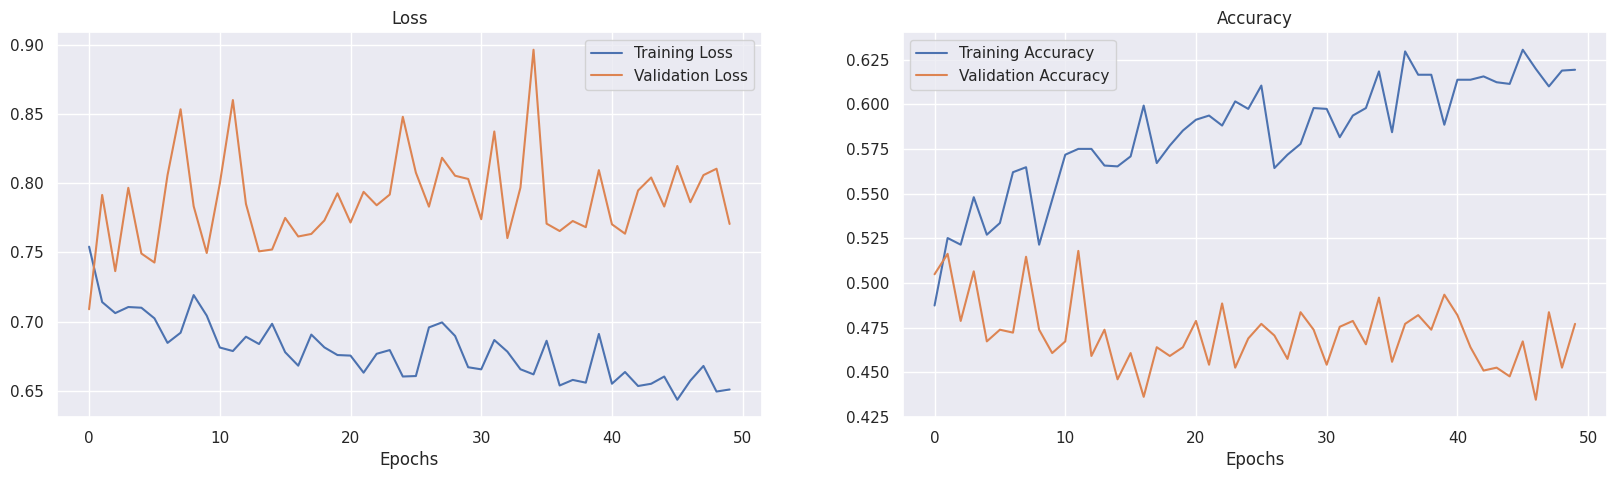

In [84]:
plot_loss_curves(train_losses, val_losses, train_accuracies, val_accuracies)

Test Loss: 0.7659, Accuracy: 48.21%


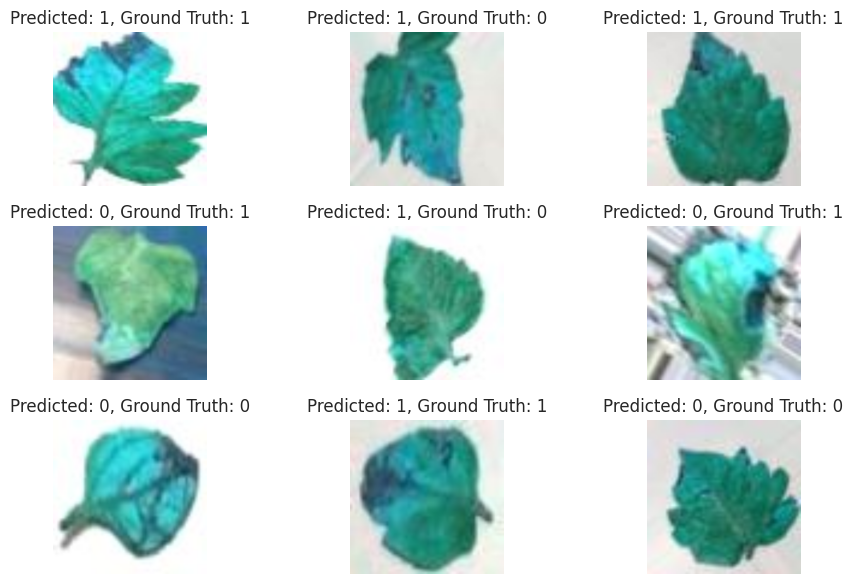

In [85]:
def evaluate_model(model, test_loader, criterion):
    model.eval() 
    test_loss = 0.0
    correct = 0
    total = 0
    losses = []
    accuracies = []
    predictions = []
    ground_truths = []

    with torch.no_grad(): 
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            losses.append(loss.item())
            accuracies.append((predicted == labels).sum().item() / labels.size(0))
            predictions.extend(predicted.cpu().numpy())
            ground_truths.extend(labels.cpu().numpy())

    avg_loss = test_loss / len(test_loader)
    accuracy = correct / total * 100
    print(f"Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

    return losses, accuracies, predictions, ground_truths

losses, accuracies, predictions, ground_truths = evaluate_model(model, test_loader, criterion)

fig, axes = plt.subplots(3, 3, figsize=(10, 6))
axes = axes.flatten()

for i in range(9): 
    image, label = test_dataset[i + 100]
    pred_label = predictions[i + 100]
    ground_truth = ground_truths[i +  100]
    image = image.permute(1, 2, 0)
    axes[i].imshow(image)
    axes[i].set_title(f"Predicted: {pred_label}, Ground Truth: {ground_truth}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()
